        Distance  Body Battery       Sleep     stress  Total Ascent  \
count  40.000000     40.000000   40.000000  40.000000     40.000000   
mean    8.868250     56.625000  424.075000  24.625000     53.075000   
std     7.216006     12.943046   39.636416  10.337106     55.001346   
min     1.120000     36.000000  300.000000  12.000000      0.000000   
25%     5.010000     46.750000  400.000000  17.750000      5.750000   
50%     6.670000     53.500000  423.500000  21.000000     36.000000   
75%    10.010000     64.250000  445.500000  30.500000    106.250000   
max    42.770000     84.000000  509.000000  52.000000    205.000000   

       Total Descent  Temperature     Avg Pace  
count      40.000000     40.00000    40.000000  
mean       52.200000     16.25250   386.900000  
std        61.719049      6.38307   157.284945  
min         0.000000      4.80000   283.000000  
25%         2.000000     11.67500   319.000000  
50%        22.500000     16.35000   340.000000  
75%       106.500

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


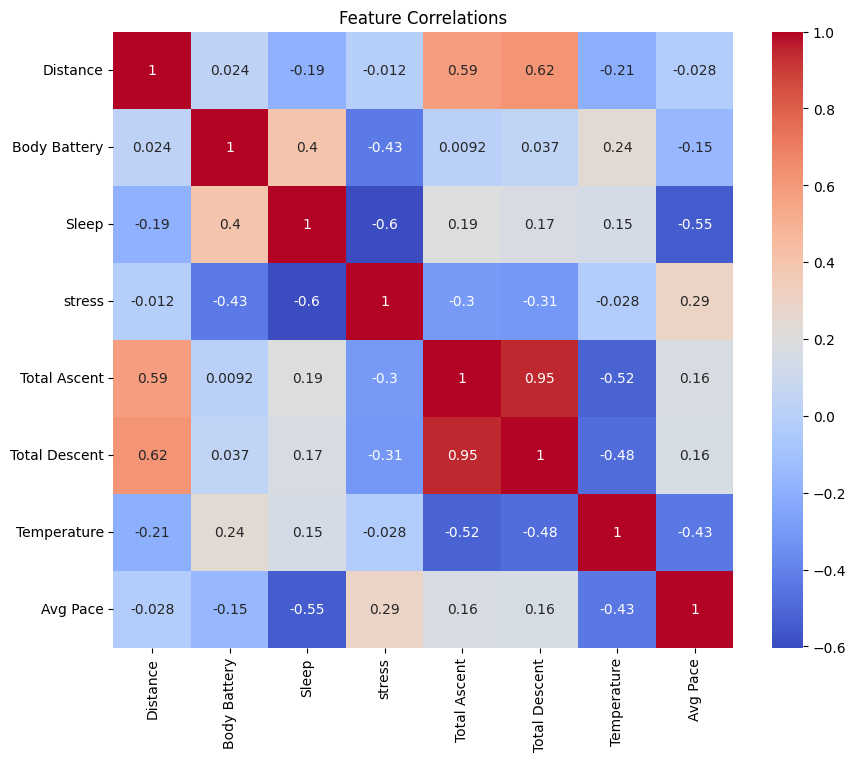

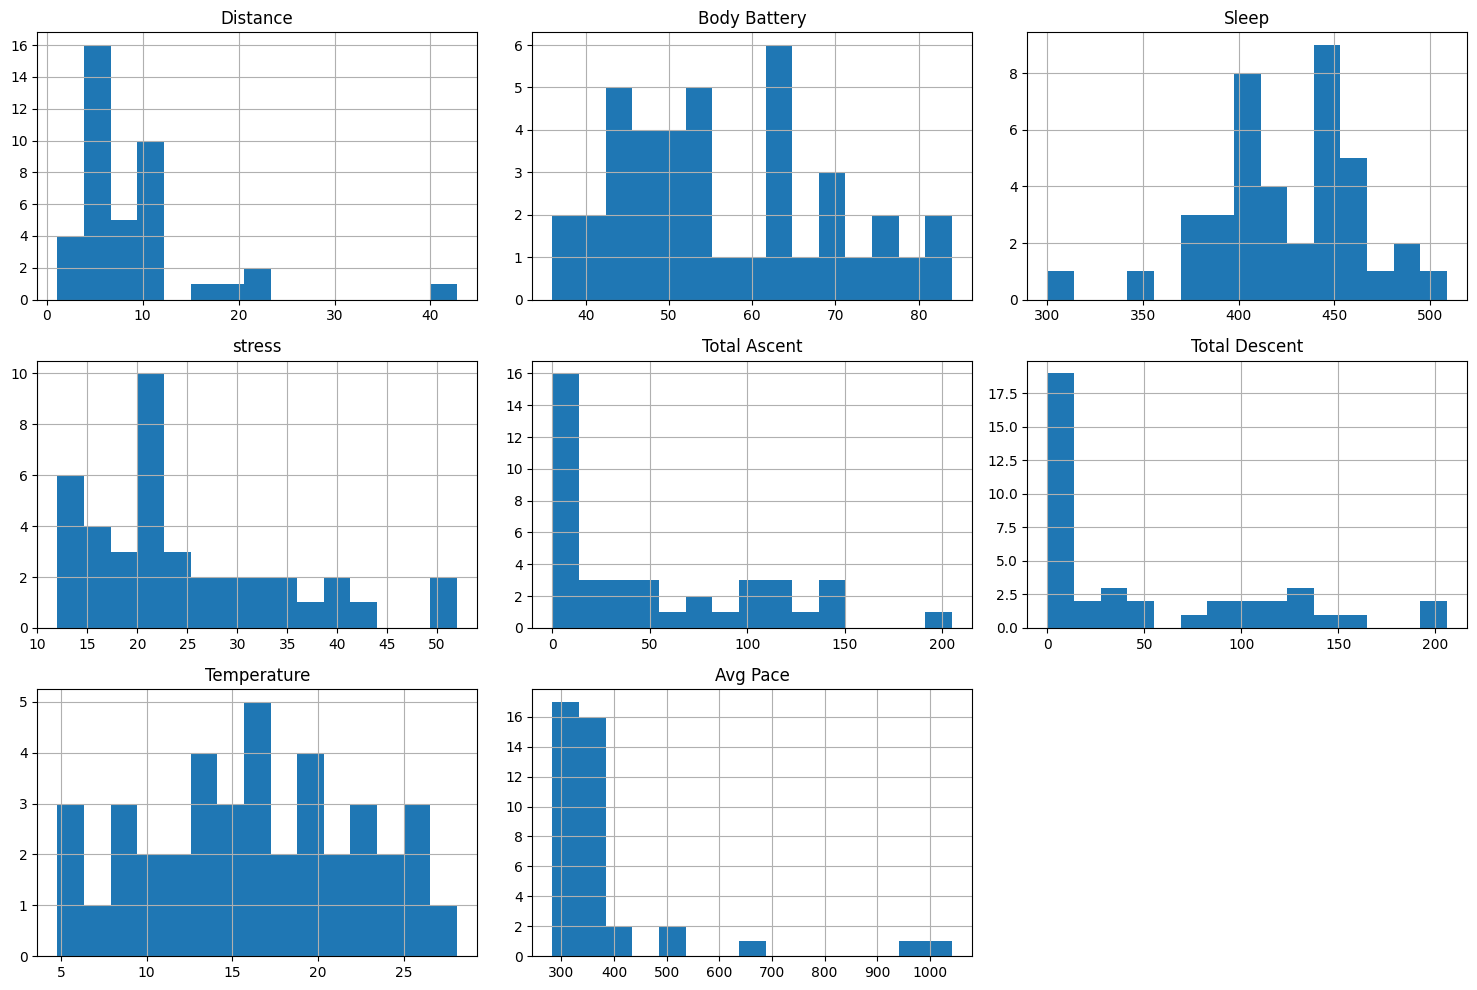

   Distance  Body Battery  Sleep  stress  Total Ascent  Total Descent  \
0      5.00            52    400      43            37             32   
1      5.01            62    430      20            22             20   
2      5.00            77    441      13            40             38   
3      5.01            84    486      14            49             48   
4      5.00            78    457      15            52             49   

   Temperature  Avg Pace  
0         25.5       319  
1         26.3       319  
2         22.7       343  
3         18.1       337  
4         11.6       359  
         Distance  Body Battery       Sleep      stress  Total Ascent  \
count  140.000000    140.000000  140.000000  140.000000    140.000000   
mean     8.467439     51.863181  408.991811   23.748988     49.008464   
std      6.658857     12.209405   40.335758    9.171581     50.997630   
min      1.029580     32.109155  283.338063   11.621847      0.000000   
25%      4.723927     42.715192  3

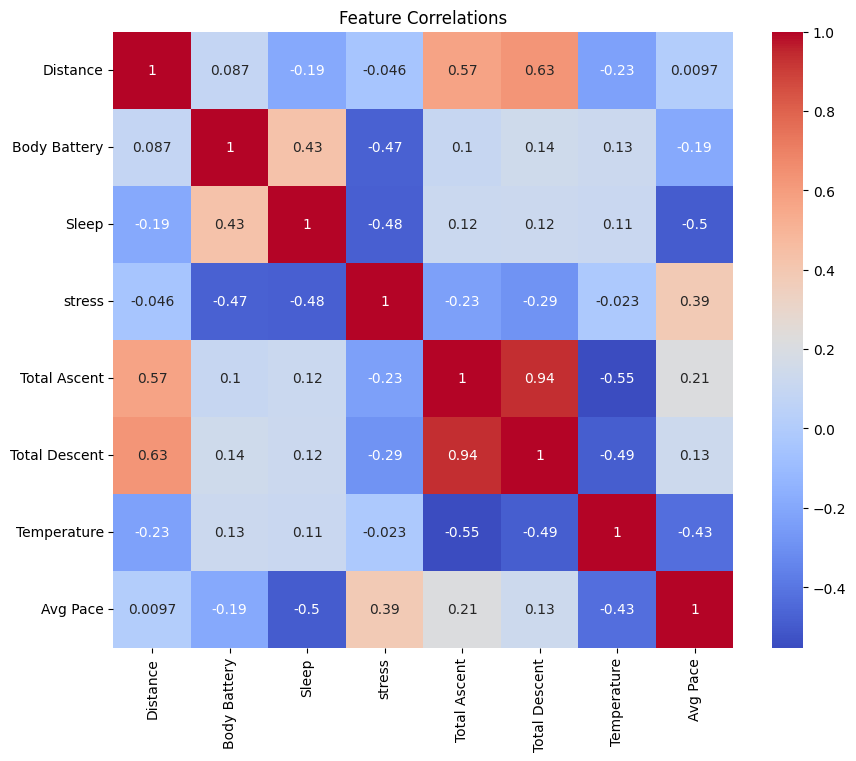

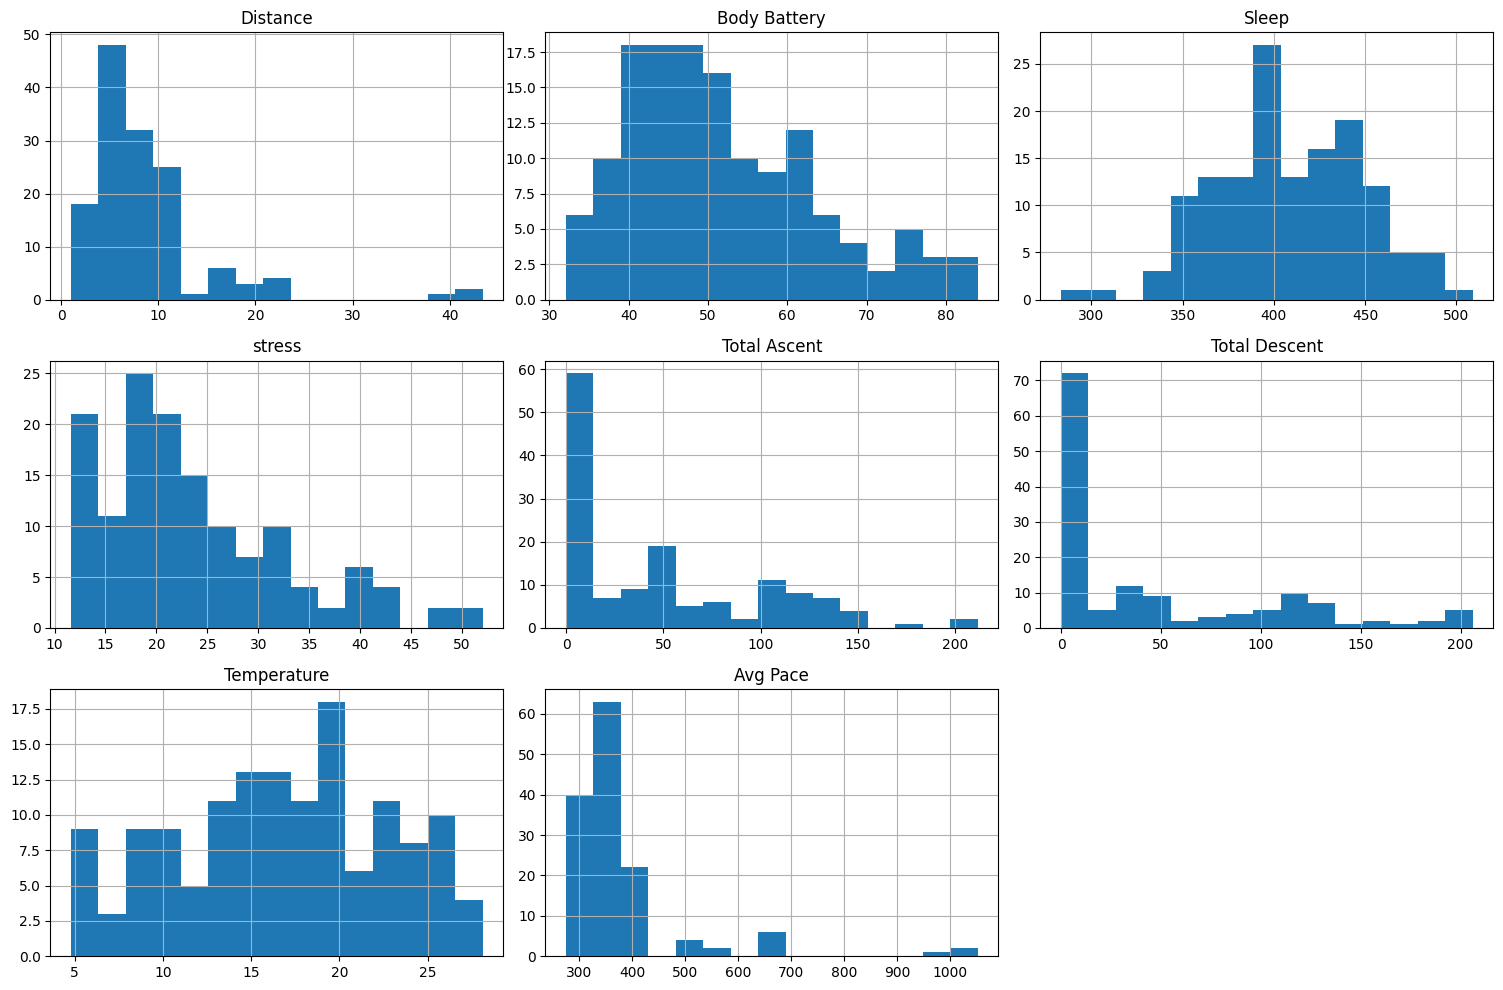

   Distance  Body Battery  Sleep  stress  Total Ascent  Total Descent  \
0      5.00          52.0  400.0    43.0          37.0           32.0   
1      5.01          62.0  430.0    20.0          22.0           20.0   
2      5.00          77.0  441.0    13.0          40.0           38.0   
3      5.01          84.0  486.0    14.0          49.0           48.0   
4      5.00          78.0  457.0    15.0          52.0           49.0   

   Temperature  Avg Pace  
0         25.5     319.0  
1         26.3     319.0  
2         22.7     343.0  
3         18.1     337.0  
4         11.6     359.0  
Epoch 50, Loss: 2091.3948
Epoch 100, Loss: 1245.7878
Epoch 150, Loss: 677.3452
Epoch 200, Loss: 282.9480
Epoch 250, Loss: 169.7573
Epoch 300, Loss: 195.2751
Epoch 350, Loss: 126.7671
Epoch 400, Loss: 84.9966
Epoch 450, Loss: 74.0391
Epoch 500, Loss: 61.7955
Epoch 550, Loss: 61.6117
Epoch 600, Loss: 99.0298
Epoch 650, Loss: 54.7381
Epoch 700, Loss: 95.4132
Epoch 750, Loss: 73.3608
Epoch 800, Loss:

In [1]:
from preprocessing import preprocess
from train import train_model
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import torch
import joblib

df = pd.read_csv("../../data/Activities-6-2-2.csv")
X_train, X_test, y_train, y_test = preprocess(df)
model, mse, r2 = train_model(X_train, y_train, X_test, y_test)

print("MSE:", mse)
print("R2:", r2)

In [7]:
# Make sure model is in eval mode
model.eval()

# Prepare new input
X_new = np.array([[5, 50, 420, 30, 18.0, 35, 30]])
scaler = joblib.load("scaler.save")
X_new_scaled = scaler.transform(X_new)
X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32)

# Predict
with torch.no_grad():
    y_pred = model(X_new_tensor).numpy().flatten()

print("Predicted:", y_pred)

Predicted: [287.08936]


In [13]:
import openrouteservice
from openrouteservice import convert

# Initialize client
client = openrouteservice.Client(
    key="eyJvcmciOiI1YjNjZTM1OTc4NTExMTAwMDFjZjYyNDgiLCJpZCI6IjEzNWMxYTFkMTA1YjRmMTM4NjVlNzM3OTZhOGQwMTgyIiwiaCI6Im11cm11cjY0In0="
)

# Set starting location: [longitude, latitude]
start_coords = [6.0839, 50.7753]  # Example: Aachen, Germany

# Parameters for a 5 km circular running route
params = {
    "coordinates": [start_coords],
    "profile": "foot-walking",
    "format_out": "geojson",
    "format": "geojson",
    "options": {
        "round_trip": {
            "length": 5000,  # meters
            "seed": 1,  # random seed to get different variations
        }
    },
}

# Request route
route_geojson = client.directions(**params)

# Extract coordinates
coordinates = route_geojson["features"][0]["geometry"]["coordinates"]

In [14]:
import requests

# Open-Elevation API expects lat/lon
locations = [{"latitude": lat, "longitude": lon} for lon, lat in coordinates]

# Prepare request body
request_json = {"locations": locations}

# Make request
response = requests.post(
    "https://api.open-elevation.com/api/v1/lookup", json=request_json
)

# Parse response
elevations = [result["elevation"] for result in response.json()["results"]]

In [16]:
import folium

# Folium expects (lat, lon), so we reverse each pair
latlon_coords = [[lat, lon] for lon, lat in coordinates]

# Center of the map
center = latlon_coords[0]

# Create a map centered on your starting point
m = folium.Map(location=center, zoom_start=15)

# Add the route as a polyline
folium.PolyLine(latlon_coords, color="blue", weight=4, opacity=0.8).add_to(m)

# Add a marker at the start
folium.Marker(center, tooltip="Start").add_to(m)

m

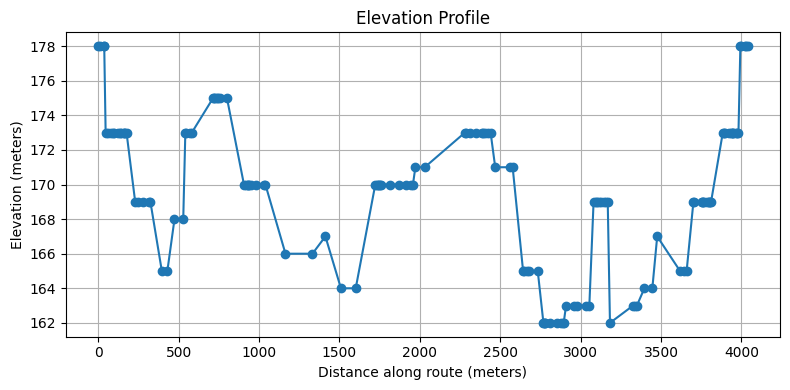

In [15]:
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Compute distances between points
distances = [0.0]
for i in range(1, len(coordinates)):
    p1 = (coordinates[i - 1][1], coordinates[i - 1][0])  # (lat, lon)
    p2 = (coordinates[i][1], coordinates[i][0])
    d = geodesic(p1, p2).meters
    distances.append(distances[-1] + d)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(distances, elevations, marker="o")
plt.xlabel("Distance along route (meters)")
plt.ylabel("Elevation (meters)")
plt.title("Elevation Profile")
plt.grid(True)
plt.tight_layout()
plt.show()